# Introduction

This will be an explanation of a dataset of properties of cars. The goal of the exploration is to use the information to predict the fuel efficiency (in miles per gallon). The dataset is contained in the file `data/auto-mpg.data` and a description of the data is in the file `data/auto-mpg.names`.

Loading required libraries:

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import floor
from os.path import join
from os import getcwd

Save random seed for reproduceability

In [85]:
random_seed = 42

Graphics save directory

In [86]:
imdir = join(getcwd(), 'report', 'images')

# Load the data

The data were loaded into a `pandas.DataFrame` object for ease of processing the mix of continuous and categorical data.

In [87]:
column_names = [
    'mpg', 'cylinders', 'displacement',
    'horsepower', 'weight', 'acceleration',
    'model year', 'origin', 'car name'
]
df = pd.read_csv('data/auto-mpg.data', header=None,
                 names=column_names, na_values='?',
                 sep='\s+')

In [88]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [89]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The dataset description calls out six missing values from the horsepower column. Since these records are relatively small compared to the rest of the dataset, for now I will delete the rows.

In [90]:
df_clean = df.dropna(axis=0)

In [91]:
df_clean.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Sure enough, 6 rows of data had NA values and have now been dropped.

# Split the data for cross-validation

Physically we would not expect that any individual car's properties should depend on any other car's properties. Therefore, if we want to divide the dataset to allow for **training**, **testing**, and **valdiation** data, we can simply randomly sample from the rows. I will use 50% of the data for training, 25% for validation, and 25% for testing and reporting.

In [92]:
def train_test_val_split(data, train_frac=0.5, test_frac=0.25, val_frac=0.25, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    else:
        np.random.seed()

    # Normalize fractions
    tot = train_frac + test_frac + val_frac
    train_frac /= tot
    test_frac /= tot
    val_frac /= tot

    numrows = data.shape[0]

    rows = np.arange(numrows)
    np.random.shuffle(rows)

    train_row_count = floor(train_frac * numrows)
    test_row_count = floor(test_frac * numrows)
    val_row_count = floor(val_frac * numrows)

    train_test_boundary = train_row_count
    test_val_boundary = train_test_boundary + test_row_count
    val_train_boundary = test_val_boundary + val_row_count

    train_rows = rows[:train_test_boundary]
    test_rows = rows[train_test_boundary:test_val_boundary]
    val_rows = rows[test_val_boundary:val_train_boundary]

    # Add leftover rows to training
    np.append(train_rows, rows[val_train_boundary:])

    train = data.loc[data.index.intersection(train_rows)]
    test = data.loc[data.index.intersection(test_rows)]
    val = data.loc[data.index.intersection(val_rows)]

    return train, test, val

In [93]:
train, test, val = train_test_val_split(df_clean, random_seed=random_seed)

# Dataset description

From the description of the dataset above (`df_clean.describe()`) we see some information fairly quickly. First, the `pandas` library is treating discrete values as continuous (luckily it was smart enough to ignore the 'car name' column).

In [94]:
continuous_columns = ['mpg', 'displacement', 'horsepower',
                      'weight', 'acceleration']

In [95]:
train_continuous = train[continuous_columns]
val_continuous = val[continuous_columns]

# Initial regression

First examine the performance of a regression using only the continuous values without rescaling the data columns.

In [96]:
class LinearRegression():
    def __init__(self):
        self.coefficients_ = None
        self.means_ = None
        self.stds_ = None
        self.x_columns_ = None
        self.y_column_ = None
    
    def fit(self, data, x_columns, y_column):
        x = data[x_columns].values
        y = data[y_column].values
        
        self.x_columns_ = x_columns
        self.y_column_ = y_column
        
        xs = self.zscore(x)
        
        # One-pad xs
        
        
        self.coefficients_ = np.linalg.inv(xs.T @ xs) @ xs.T @ y
        
    def zscore(self, x):
        # Make sure x is 2-d
        if len(x.shape) < 2:
            x = x.reshape((-1, 1))
        
        if self.means_ is None and self.stds_ is None:
            self.means_ = np.mean(x, axis=0)
            self.stds_ = np.std(x, axis=0)
        
        xs = (x - self.means_) / self.stds_
        
        # Add column of ones
        o = np.ones_like(xs[:,0]).reshape((-1, 1))
        xs = np.hstack([xs, o])
        
        return xs
        
    def predict(self, data):
        x = data[self.x_columns_].values
        xs = self.zscore(x)
        
        y_pred = xs @ self.coefficients_
        
        return y_pred
    
    def rmse(self, data):
        yp = self.predict(data)
        yt = data[self.y_column_].values
        
        se = (yp - yt) ** 2
        mse = np.mean(se)
        rmse = np.sqrt(mse)
        
        return rmse

In [97]:
lr = LinearRegression()
lr.fit(train, continuous_columns[1:], ['mpg'])

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


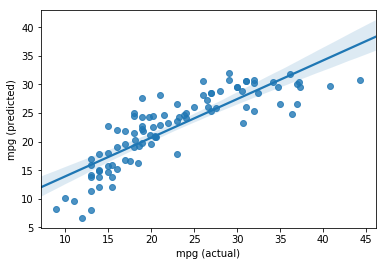

In [98]:
sns.regplot(x=test['mpg'], 
            y=lr.predict(test).ravel())
plt.xlabel('mpg (actual)')
plt.ylabel('mpg (predicted)')
plt.show()

A perfect fit would have a slope of one and an intercept of zero. Looks like more digging is necessary

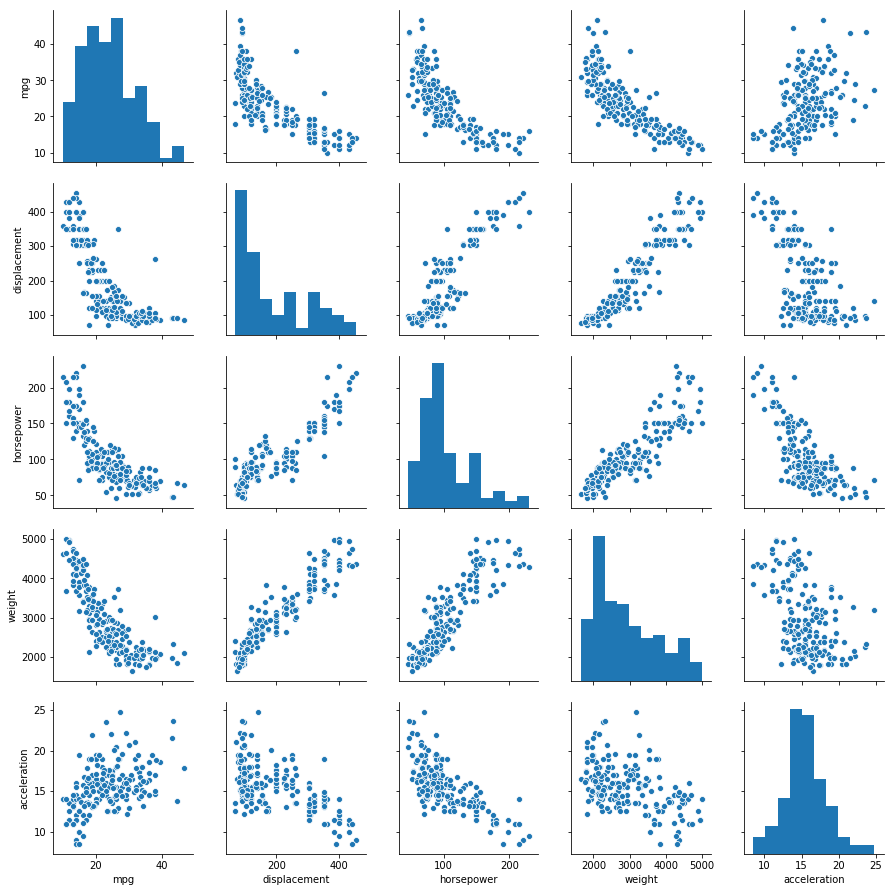

In [99]:
sns.pairplot(train_continuous)
plt.savefig(join(imdir, 'continuous_pairplot.png'), dpi=300)
plt.show()

This shows us that the relationship between mpg and displacement, horsepower, and weight do not appear to be linear--it looks like either a $\mathrm{e}^{-x}$ or $1/x$ relationship. To validate, let's plot mpg vs. horsepower^-1 and mpg vs log(horsepower)

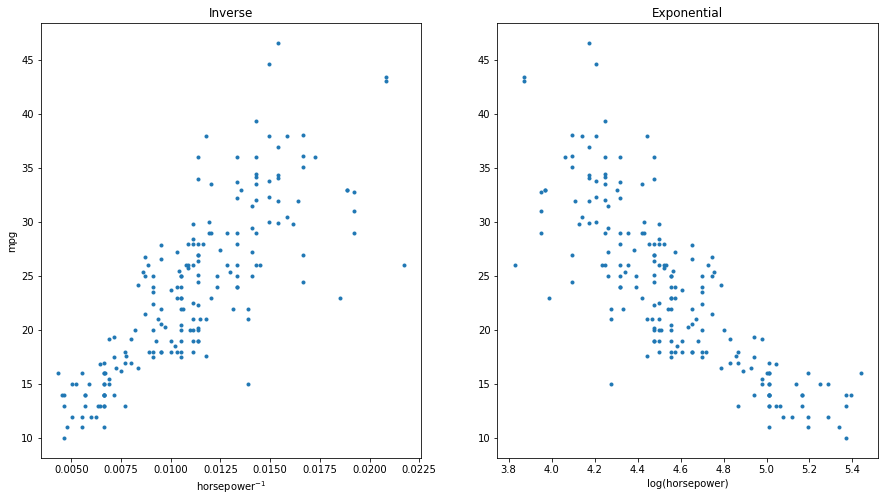

In [100]:
f = plt.figure(figsize=(15, 8))

ax1 = f.add_subplot(121)
ax1.plot(1/train['horsepower'], train['mpg'], '.')
ax1.set_title('Inverse')
ax1.set_xlabel(r'horsepower$^{-1}$')
ax1.set_ylabel('mpg')

ax2 = f.add_subplot(122, sharey=ax1)
ax2.plot(np.log(train['horsepower']), train['mpg'], '.')
ax2.set_title('Exponential')
ax2.set_xlabel('log(horsepower)')

plt.savefig(join(imdir, 'inverse_and_exponential_horsepower.png'), dpi=300)
plt.show()

These look more linear, but as a guess I am going to assume that the parameter to use is $1/horsepower$. Similarly, I will fit $1/displacement$ and $1/weight$

In [101]:
for dataset in (train, test, val):
    dataset['inverse horsepower'] = dataset['horsepower'] ** -1
    dataset['inverse displacement'] = dataset['displacement'] ** -1
    dataset['inverse weight'] = dataset['weight'] ** -1
continuous_columns.extend(['inverse horsepower', 
                           'inverse displacement', 'inverse weight'])
train_continuous = train[continuous_columns]

In [102]:
train.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name',
       'inverse horsepower', 'inverse displacement', 'inverse weight'],
      dtype='object')

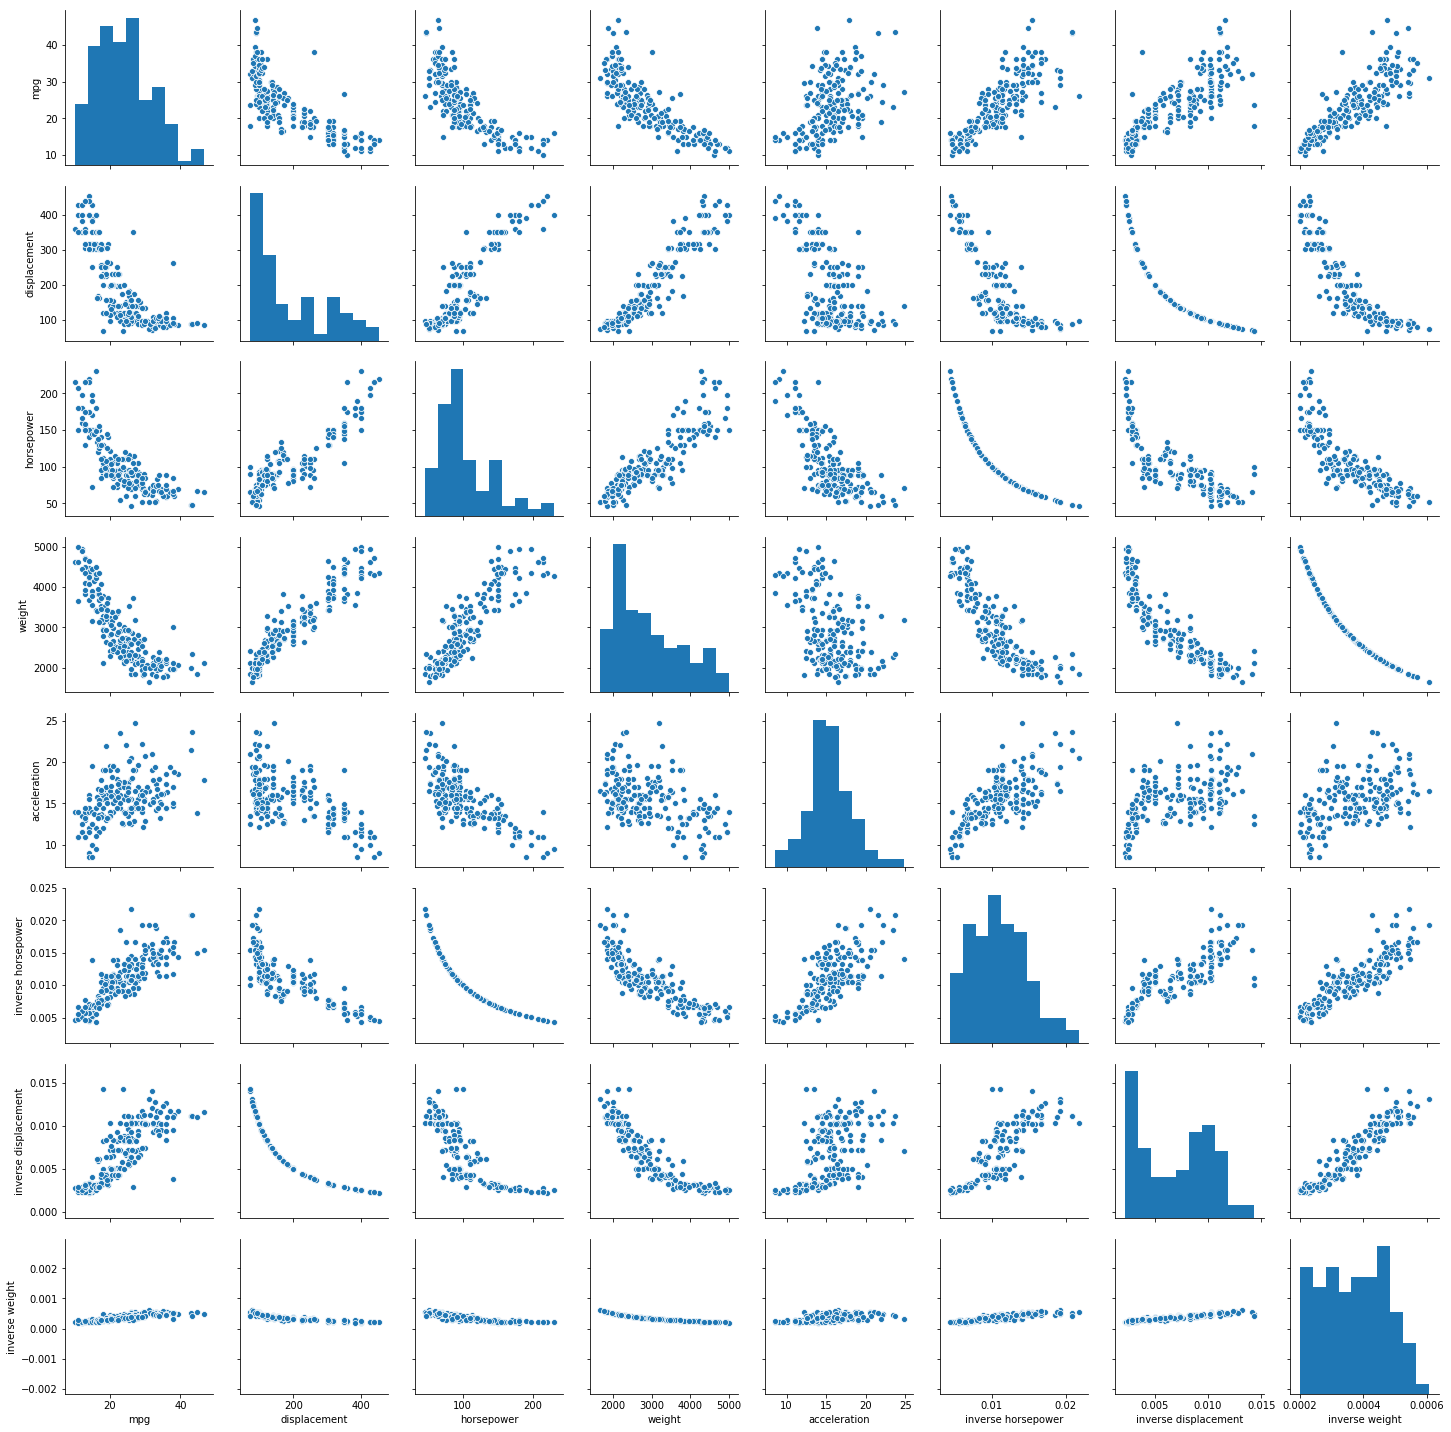

In [103]:
sns.pairplot(train_continuous)
plt.show()

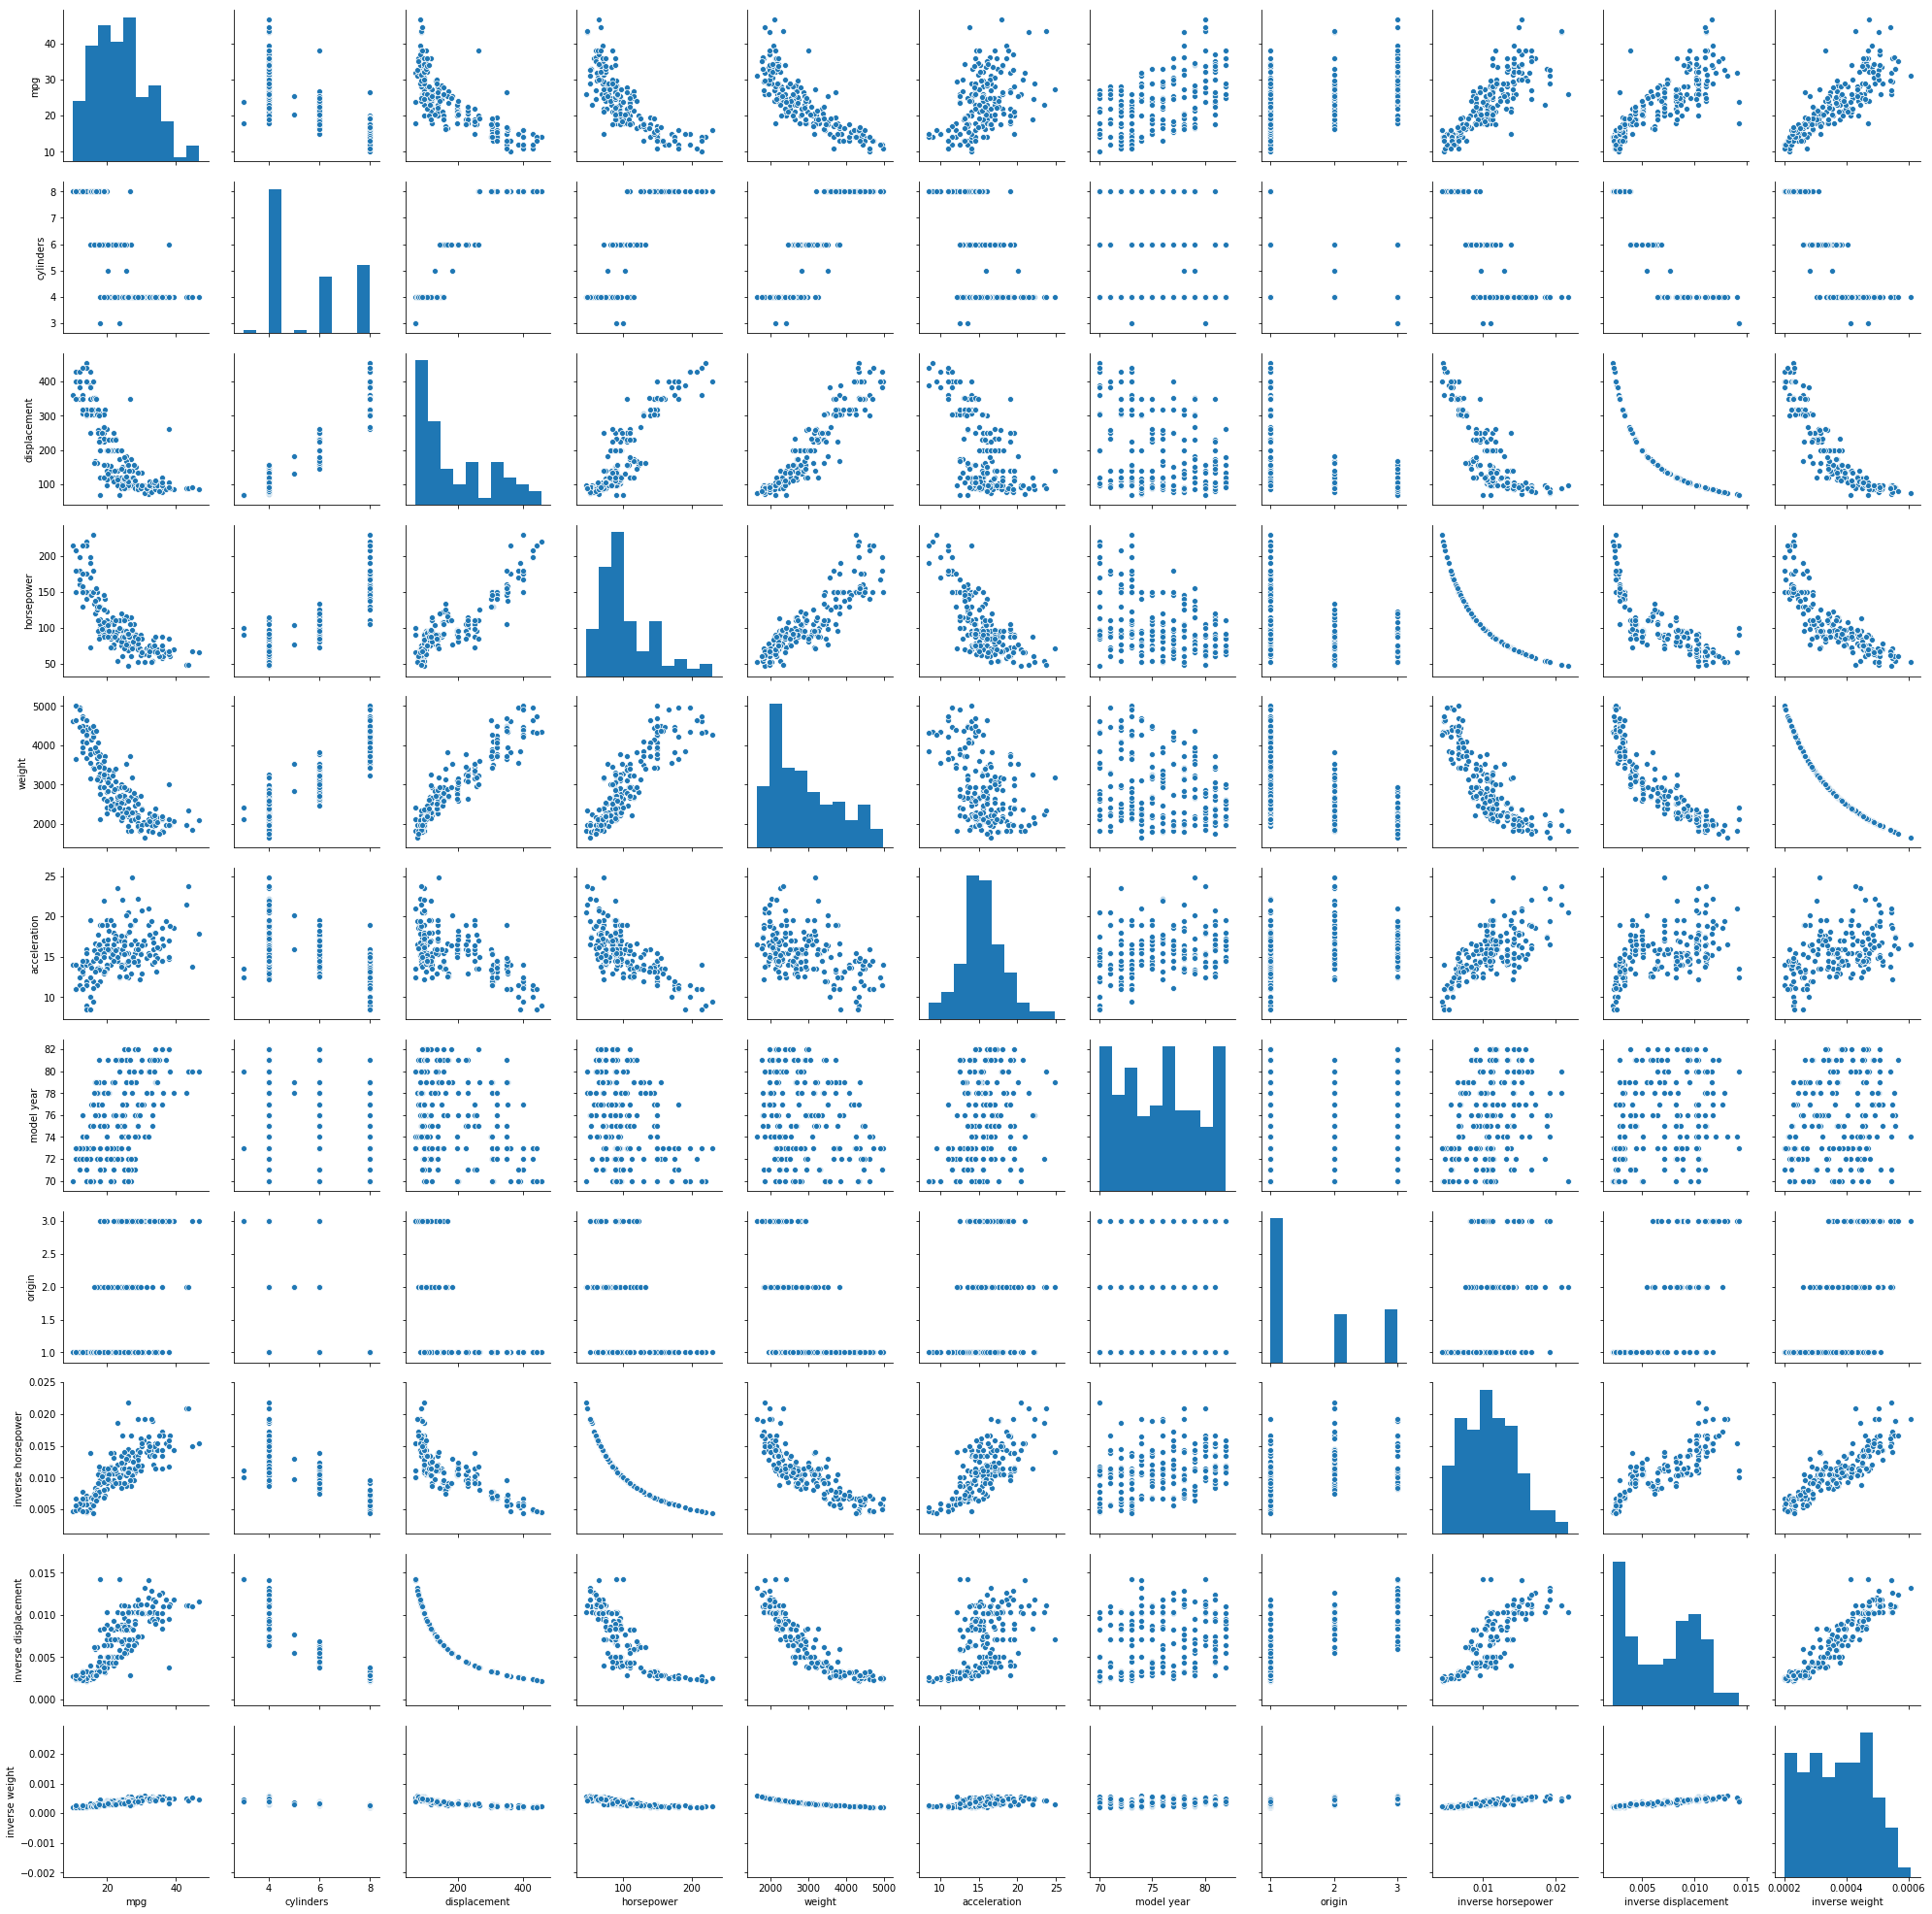

In [104]:
sns.pairplot(train)
plt.show()

There appear to be some funny things going on in the "cylinders" column. These are typically paired, so odd numbers are unusual. Let's look at that.

In [105]:
train[train.cylinders%2!=0]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,inverse horsepower,inverse displacement,inverse weight
111,18.0,3,70.0,90.0,2124.0,13.5,73,3,maxda rx3,0.011111,0.014286,0.000471
274,20.3,5,131.0,103.0,2830.0,15.9,78,2,audi 5000,0.009709,0.007634,0.000353
297,25.4,5,183.0,77.0,3530.0,20.1,79,2,mercedes benz 300d,0.012987,0.005464,0.000283
334,23.7,3,70.0,100.0,2420.0,12.5,80,3,mazda rx-7 gs,0.010000,0.014286,0.000413


A wikipedia search for the [Mercedes 300D](https://en.wikipedia.org/wiki/Mercedes-Benz_W123) reveals that it was, in fact, offered in an inline-5 cylinder configuration.

On the other hand, the [Mazda RX-4](https://en.wikipedia.org/wiki/Mazda_Luce#Mazda_RX-4) was not offered in a 3-cylinder configuration. It's possible that this refers to the rotary Wankel engine. Cars with this engine were sold during this time period, which provides some coroborating evidence.

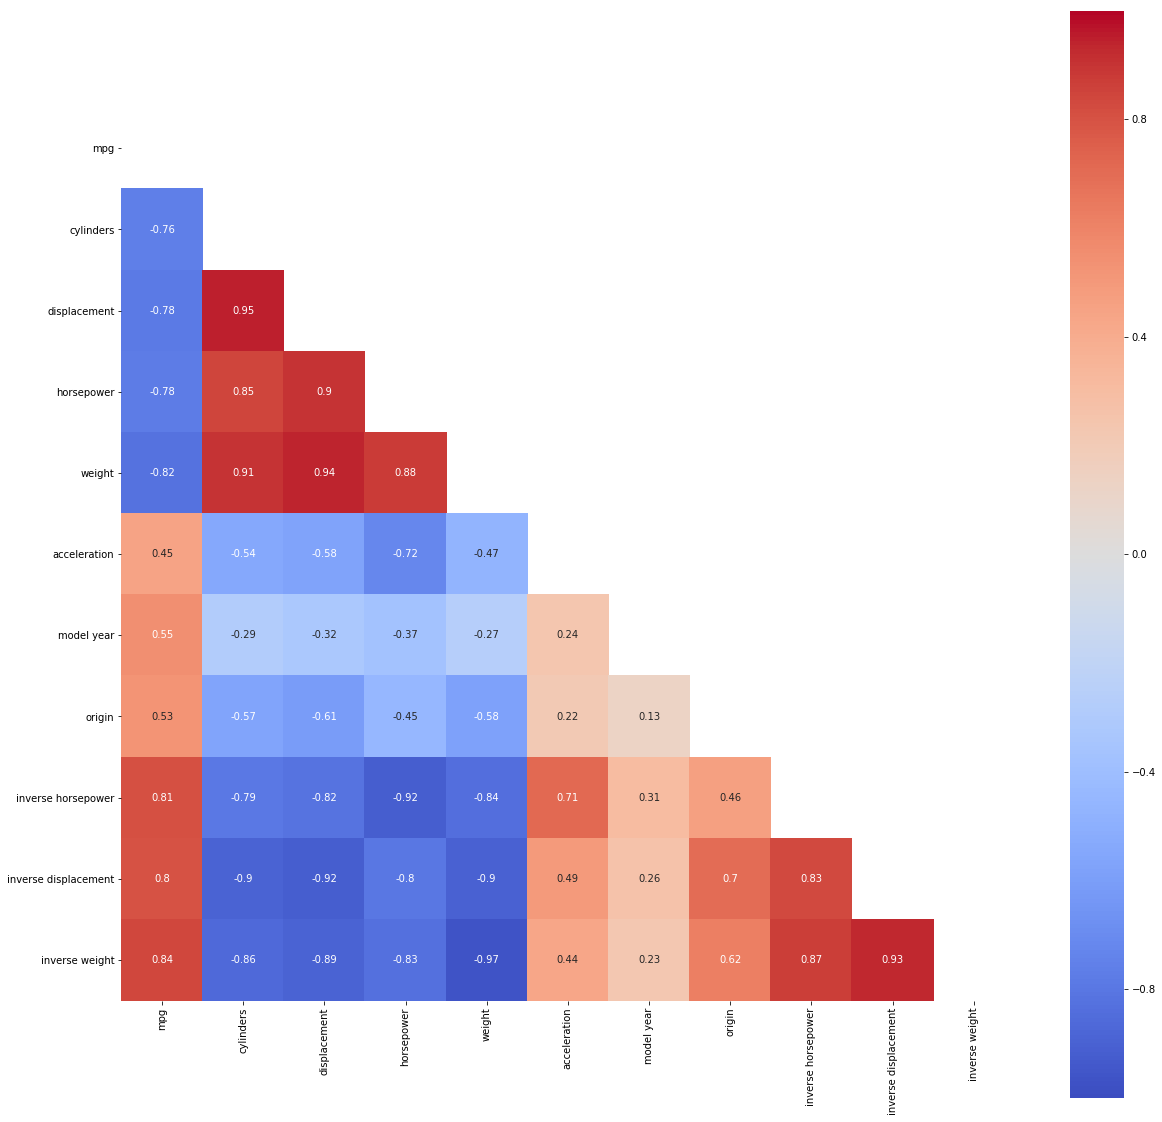

In [106]:
f = plt.figure(figsize=(20,20))
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm', square=True, mask=mask)
plt.show()

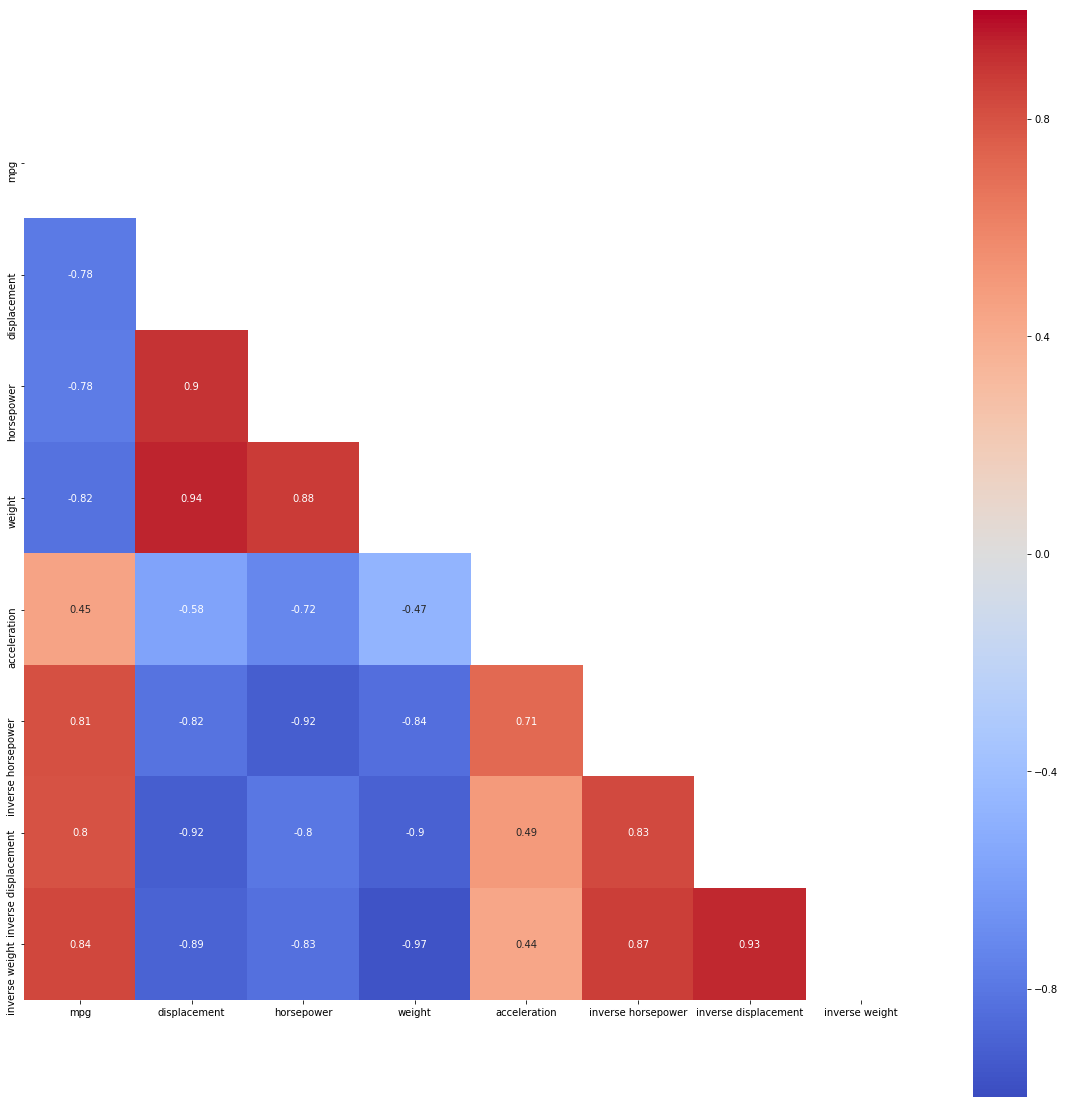

In [107]:
f = plt.figure(figsize=(20,20))
mask = np.zeros_like(train_continuous.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_continuous.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm', square=True, mask=mask)
plt.show()

From this wee can see that displacement, horsepower, and weight are negatively correlated with mpg. Counterintuitively, acceleration is positively correlated with mpg.

Just for fun, let's try to figure out what the origin codes ("1", "2", and "3") correspond to

In [108]:
train[train.origin==1].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,inverse horsepower,inverse displacement,inverse weight
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,0.007692,0.003257,0.000285
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0.006667,0.003289,0.000291
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500,0.005051,0.002331,0.000230
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala,0.004545,0.002203,0.000230
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii,0.004651,0.002273,0.000232


In [109]:
train[train.origin==2].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,inverse horsepower,inverse displacement,inverse weight
19,26.0,4,97.0,46.0,1835.0,20.5,70,2,volkswagen 1131 deluxe sedan,0.021739,0.010309,0.000545
22,25.0,4,104.0,95.0,2375.0,17.5,70,2,saab 99e,0.010526,0.009615,0.000421
23,26.0,4,121.0,113.0,2234.0,12.5,70,2,bmw 2002,0.008850,0.008264,0.000448
55,27.0,4,97.0,60.0,1834.0,19.0,71,2,volkswagen model 111,0.016667,0.010309,0.000545
59,23.0,4,97.0,54.0,2254.0,23.5,72,2,volkswagen type 3,0.018519,0.010309,0.000444


In [110]:
train[train.origin==3].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,inverse horsepower,inverse displacement,inverse weight
18,27.0,4,97.0,88.0,2130.0,14.5,70,3,datsun pl510,0.011364,0.010309,0.000469
31,25.0,4,113.0,95.0,2228.0,14.0,71,3,toyota corona,0.010526,0.008850,0.000449
57,24.0,4,113.0,95.0,2278.0,15.5,72,3,toyota corona hardtop,0.010526,0.008850,0.000439
81,28.0,4,97.0,92.0,2288.0,17.0,72,3,datsun 510 (sw),0.010870,0.010309,0.000437
82,23.0,4,120.0,97.0,2506.0,14.5,72,3,toyouta corona mark ii (sw),0.010309,0.008333,0.000399


It appears that origin "1" is the United States, origin "2" is Europe, and origin "3" is Japan (or possibly Asia).

There are two 6-cylinder cars that appear to be outliers in mpg. Let's take a look  and validate the maximum of those.

In [111]:
train[train.cylinders==6].loc[train[train.cylinders==6]['mpg'].idxmax()]

mpg                                                    38
cylinders                                               6
displacement                                          262
horsepower                                             85
weight                                               3015
acceleration                                           17
model year                                             82
origin                                                  1
car name                oldsmobile cutlass ciera (diesel)
inverse horsepower                              0.0117647
inverse displacement                           0.00381679
inverse weight                                0.000331675
Name: 387, dtype: object

In fact, let's look at boxplots to examine the categorical attributes and determine 

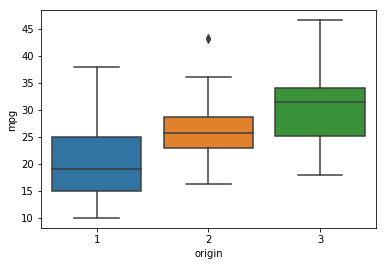

In [112]:
sns.boxplot(x='origin', y='mpg', data=train)
plt.savefig(join(imdir, 'mpg_vs_origin.png'), dpi=300)
plt.show()

Here we can see that Japan has the highest gas mileage, America the lowest, and Europe somewhere in between. Based on these differences it is probably worthwhile to develop a category-aware model, or three separate models (one for each origin).

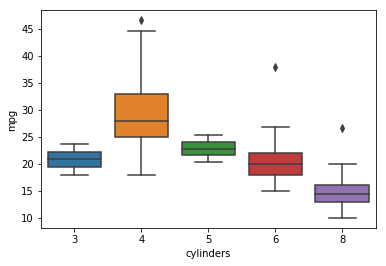

In [113]:
sns.boxplot(x='cylinders', y='mpg', data=train)
plt.show()

This shows the inverse trend of cylinder numbers to mpg. It also suggests that the 3- and 5-cylinder cars may not be representative of this overall trend and arguably should be thrown out.

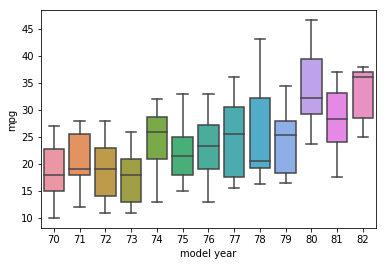

In [114]:
sns.boxplot(x='model year', y='mpg', data=train)
plt.savefig(join(imdir, 'mpg_vs_year.png'), dpi=300)
plt.show()

Here we can see the trend of the quasi-continuous (but actually discrete) variable `model year` vs. gas mileage. There's no clean relationship here, which belies the correlation calculated above.

It looks like 1978 has some high mpg examples--several sigma above the mean. Let's look more closely at those.

In [115]:
train[train['model year'] == 78].sort_values('mpg')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,inverse horsepower,inverse displacement,inverse weight
277,16.2,6,163.0,133.0,3410.0,15.8,78,2,peugeot 604sl,0.007519,0.006135,0.000293
275,17.0,6,163.0,125.0,3140.0,13.6,78,2,volvo 264gl,0.008000,0.006135,0.000318
265,17.5,8,318.0,140.0,4080.0,13.7,78,1,dodge magnum xe,0.007143,0.003145,0.000245
262,19.2,8,305.0,145.0,3425.0,13.2,78,1,chevrolet monte carlo landau,0.006897,0.003279,0.000292
250,19.4,8,318.0,140.0,3735.0,13.2,78,1,dodge diplomat,0.007143,0.003145,0.000268
274,20.3,5,131.0,103.0,2830.0,15.9,78,2,audi 5000,0.009709,0.007634,0.000353
253,20.5,6,200.0,95.0,3155.0,18.2,78,1,chevrolet malibu,0.010526,0.005000,0.000317
258,20.6,6,231.0,105.0,3380.0,15.8,78,1,buick century special,0.009524,0.004329,0.000296
255,25.1,4,140.0,88.0,2720.0,15.4,78,1,ford fairmont (man),0.011364,0.007143,0.000368
268,27.2,4,119.0,97.0,2300.0,14.7,78,3,datsun 510,0.010309,0.008403,0.000435


In [116]:
train[train['model year'] == 78].describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,inverse horsepower,inverse displacement,inverse weight
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,15.000000
mean,25.726667,5.400000,168.066667,98.133333,2800.333333,16.020000,78.0,1.866667,0.011549,0.007485,0.000382
std,8.793623,1.594634,87.263531,33.217609,738.150359,2.444294,0.0,0.833809,0.004510,0.003406,0.000104
min,16.200000,4.000000,78.000000,48.000000,1800.000000,13.200000,78.0,1.000000,0.006897,0.003145,0.000245
25%,19.300000,4.000000,90.500000,70.500000,2030.000000,14.200000,78.0,1.000000,0.007759,0.004665,0.000295
50%,20.600000,5.000000,140.000000,97.000000,2830.000000,15.800000,78.0,2.000000,0.010309,0.007143,0.000353
75%,32.150000,6.000000,215.500000,129.000000,3395.000000,17.300000,78.0,2.500000,0.014185,0.011050,0.000493
max,43.100000,8.000000,318.000000,145.000000,4080.000000,21.500000,78.0,3.000000,0.020833,0.012821,0.000556


Did the Ford Fiesta *really* get 36.1 mpg? While it is the lightest car of the year, this is also worth checking out and potentially rejecting. As it turns out, the car was [reported](https://www.cargurus.com/Cars/1978-Ford-Fiesta-Reviews-c9312) to get excellent gas mileage--this is probably a real data point.

Based on this, it appears that outliers are not especially concerning.

We should check to see how many American cars there are vice the other two origins. If the dataset is weighted it may be necessary to use a more advanced sampling procedure.

In [117]:
len(train[train['origin'] == 1])

114

In [118]:
len(train[train['origin'] == 2])

38

In [119]:
len(train[train['origin'] == 3])

42

Sure enough, this is unbalanced. This is an excellent argument for generating three different models.

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


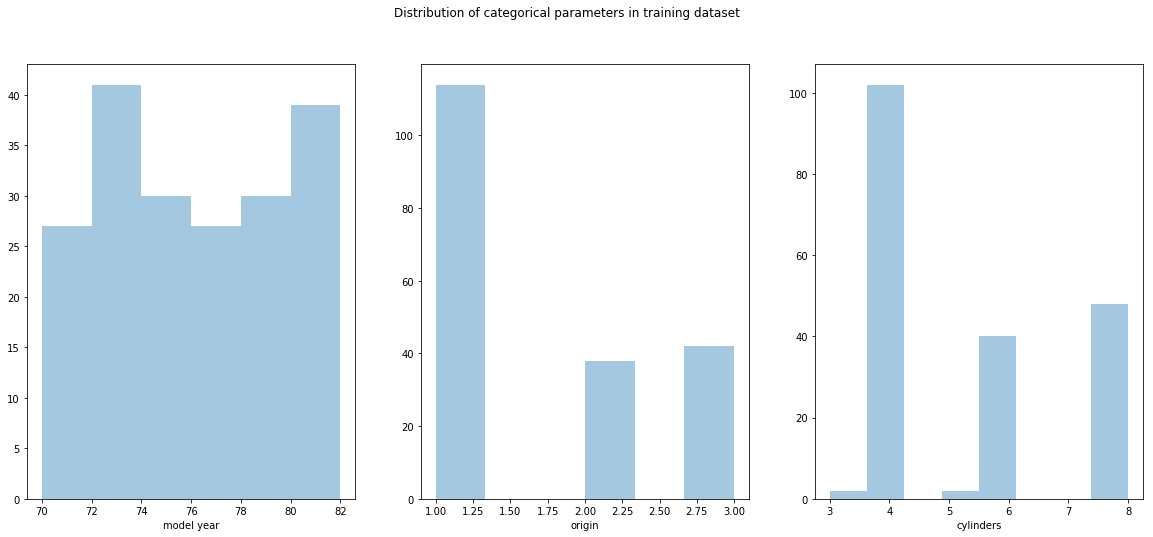

In [120]:
f = plt.figure(figsize=(20, 8))

f.add_subplot(131)
sns.distplot(train['model year'], kde=False)

f.add_subplot(132)
sns.distplot(train['origin'], kde=False)

f.add_subplot(133)
sns.distplot(train['cylinders'], kde=False)

f.suptitle('Distribution of categorical parameters in training dataset')

plt.savefig(join(imdir, 'categorical_distribution.png'), dpi=300)
plt.show()

Distribution across model years number of cylinders is fairly even.

# Summary

- Split the origin of the cars by country
    - Can make 3 models (one for each region)
    - Can one-hot encode
- Include year as an input, it's correlated 
- Calculate the inverse of the weight, displacement, and horsepower
- Cylinders is also strongly correlated
    - Can use as input but throw out cars with odd numbers of cylinders
    - Can one-hot encode
    - Can ignore as input

# Make a linear regression tool

In [121]:
train_continuous.columns

Index(['mpg', 'displacement', 'horsepower', 'weight', 'acceleration',
       'inverse horsepower', 'inverse displacement', 'inverse weight'],
      dtype='object')

# Regression on one column

In [122]:
one_var_regression = []
for column in train_continuous.columns[1:]:
    model = LinearRegression()
    model.fit(train, [column], ['mpg'])
    one_var_regression.append({
        'name': column,
        'model': model,
        'performance': model.rmse(test)
    })


In [123]:
for m in one_var_regression:
    print(f"{m['name']}\t{m['performance']}")

displacement	4.366985707092861
horsepower	4.894898906789425
weight	4.241479426532961
acceleration	7.3651971223062995
inverse horsepower	4.344884244138614
inverse displacement	4.1363158374882225
inverse weight	4.215079885267199


So inverse horsepower is apparently the best single predictor, even though it was not the most strongly correlated.

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


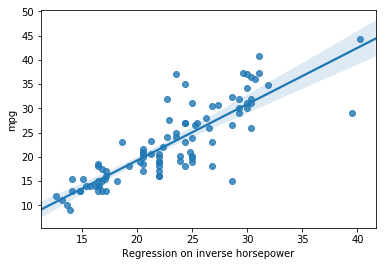

In [124]:
sns.regplot(x=one_var_regression[4]['model'].predict(test).ravel(), y=test['mpg'])
plt.xlabel(f"Regression on {one_var_regression[4]['name']}")
plt.show()

## Regression on two columns

Now to find the best combination of two input columns

In [125]:
from itertools import combinations

In [126]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 2)]

In [127]:
two_var_regression = []
for c in cs:
    model = LinearRegression()
    model.fit(train, c, ['mpg'])
    two_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })

In [128]:
for m in two_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower']	4.344866199102984
['displacement', 'weight']	4.211041633397988
['displacement', 'acceleration']	4.36754900949919
['displacement', 'inverse horsepower']	3.9422396939782383
['displacement', 'inverse displacement']	4.0260474669980635
['displacement', 'inverse weight']	4.072163105232825
['displacement', 'model year']	3.7627113670615744
['horsepower', 'weight']	4.161177036367438
['horsepower', 'acceleration']	4.752999094756579
['horsepower', 'inverse horsepower']	4.3584278342993255
['horsepower', 'inverse displacement']	3.859942709949328
['horsepower', 'inverse weight']	3.977760367924006
['horsepower', 'model year']	4.4881349960292445
['weight', 'acceleration']	4.200694339070752
['weight', 'inverse horsepower']	3.879064154086528
['weight', 'inverse displacement']	3.968076129052075
['weight', 'inverse weight']	4.153079799701626
['weight', 'model year']	3.430360676430947
['acceleration', 'inverse horsepower']	4.065737026894758
['acceleration', 'inverse displacem

The best two variable model appears to be a combination of `model year` and `inverse displacement`, with a test set RMSE of 3.12. It does appear that the model loses precision at higher mpg cars.

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


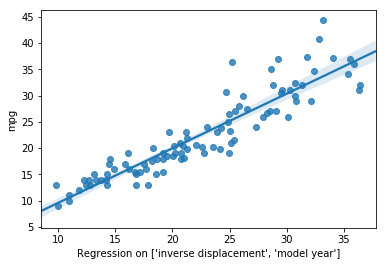

In [129]:
sns.regplot(x=two_var_regression[-1]['model'].predict(test).ravel(), y=test['mpg'])
plt.xlabel(f"Regression on {two_var_regression[-2]['name']}")
plt.show()

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


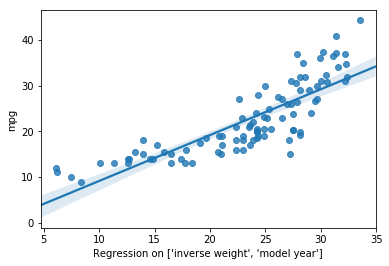

In [130]:
sns.regplot(x=two_var_regression[12]['model'].predict(test).ravel(), y=test['mpg'])
plt.xlabel(f"Regression on {two_var_regression[-1]['name']}")
plt.show()

## Three variable regression

In [131]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 3)]
three_var_regression = []
for c in cs:
    model = LinearRegression()
    model.fit(train, c, ['mpg'])
    three_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })
for m in three_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower', 'weight']	4.235215933965405
['displacement', 'horsepower', 'acceleration']	4.280679673264711
['displacement', 'horsepower', 'inverse horsepower']	3.883050779113867
['displacement', 'horsepower', 'inverse displacement']	3.8815070165695356
['displacement', 'horsepower', 'inverse weight']	4.004739954208171
['displacement', 'horsepower', 'model year']	3.8357446867842806
['displacement', 'weight', 'acceleration']	4.228029085810836
['displacement', 'weight', 'inverse horsepower']	3.892591878845366
['displacement', 'weight', 'inverse displacement']	4.014626162400922
['displacement', 'weight', 'inverse weight']	4.076344976214774
['displacement', 'weight', 'model year']	3.528578420399024
['displacement', 'acceleration', 'inverse horsepower']	3.685369823928484
['displacement', 'acceleration', 'inverse displacement']	4.034090730991662
['displacement', 'acceleration', 'inverse weight']	4.071561989282681
['displacement', 'acceleration', 'model year']	3.72795988223202


In [132]:
three_var_perf = [m['performance'] for m in three_var_regression]
three_var_best_model = three_var_regression[three_var_perf.index(min(three_var_perf))]
print(three_var_best_model)

{'name': ['inverse horsepower', 'inverse weight', 'model year'], 'model': <__main__.LinearRegression object at 0x1a24632f28>, 'performance': 3.047866982113797}


## Performance of best model vs. input size

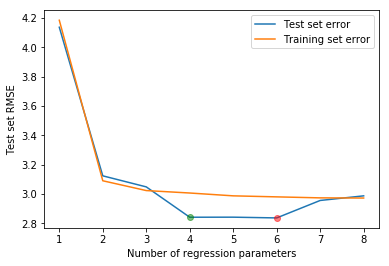

In [133]:
input_columns = continuous_columns[1:] + ['model year']
best_model_perf = []
best_model_train_perf = []
for i in range(1,len(input_columns)+1):
    cs = [list(_) for _ in combinations(input_columns, i)]
    #print(cs)
    best_perf = 1000000
    best_train_perf = 1000000
    for c in cs:
        model = LinearRegression()
        model.fit(train, c, ['mpg'])
        best_perf = min([model.rmse(test), best_perf])
        best_train_perf = min([model.rmse(train), best_train_perf])
    best_model_perf.append(best_perf)
    best_model_train_perf.append(best_train_perf)
plt.plot(best_model_perf, label="Test set error")
plt.plot(best_model_train_perf, label="Training set error")
plt.plot(best_model_perf.index(min(best_model_perf)), 
         min(best_model_perf), 'ro', alpha=0.5)
plt.plot(3, best_model_perf[3], 'go', alpha=0.5)
plt.xlabel('Number of regression parameters')
plt.ylabel('Test set RMSE')
xticks = [_ for _ in range(len(best_model_perf))]
xtick_labels = [_+1 for _ in range(len(best_model_perf))]
plt.xticks(xticks, xtick_labels)
plt.legend(loc='upper right')
plt.savefig(join(imdir, 'performance_vs_model_size.png'), dpi=300)
plt.show()

In [134]:
best_model_perf[3]

2.840922005386737

In [135]:
best_model_perf[5]

2.8362554485355336

While it appears that the best model is made when six parameters are included, the performance of the 6-input model is not markedly better (on the test set) than the 4-input model. At this point I would select the 4-input model as the best based on its combination of accuracy and (presumably) higher generalizability.

In [136]:
input_columns = continuous_columns[1:] + ['model year']
cs = [list(_) for _ in combinations(input_columns, 4)]
best_model_perf = []
models = []
#print(cs)
best_perf = 1000000
for c in cs:
    model = LinearRegression()
    model.fit(train, c, ['mpg'])
    best_perf = min([model.rmse(test), best_perf])
    best_model_perf.append(model.rmse(test))
    models.append(model)
print(f"The best model had an RMSE of {best_perf}")
index = best_model_perf.index(best_perf)
inputs = cs[index]
print(f"It had a performance of {best_perf}")
print(f"Its inputs were {inputs}")

The best model had an RMSE of 2.840922005386737
It had a performance of 2.840922005386737
Its inputs were ['acceleration', 'inverse horsepower', 'inverse displacement', 'model year']


In [137]:
input_columns = continuous_columns[1:] + ['model year']
cs = [list(_) for _ in combinations(input_columns, 6)]
best_model_perf = []
models = []
#print(cs)
best_perf = 1000000
for c in cs:
    model = LinearRegression()
    model.fit(train, c, ['mpg'])
    best_perf = min([model.rmse(test), best_perf])
    best_model_perf.append(model.rmse(test))
    models.append(model)
print(f"The best model had an RMSE of {best_perf}")
index = best_model_perf.index(best_perf)
inputs = cs[index]
print(f"It had a performance of {best_perf}")
print(f"Its inputs were {inputs}")

The best model had an RMSE of 2.8362554485355336
It had a performance of 2.8362554485355336
Its inputs were ['displacement', 'horsepower', 'acceleration', 'inverse horsepower', 'inverse displacement', 'model year']


In [138]:
tmp = train[
    ['acceleration',
     'inverse horsepower',
     'inverse displacement',
     'model year']
].values
np.linalg.cond(tmp)

60905.256643883244

In [139]:
tmp = train[
    ['displacement',
     'horsepower',
     'acceleration',
     'inverse horsepower',
     'inverse displacement',
     'model year']
].values
np.linalg.cond(
    tmp
)

348028.6466326054

## Regression on all continuous columns

In [140]:
all_col_model = LinearRegression()
all_col_model.fit(train, continuous_columns[1:], ['mpg'])
all_col_model.rmse(test)

3.7285371880926066

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


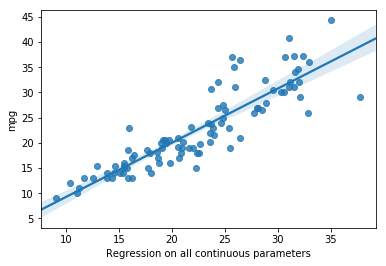

In [141]:
sns.regplot(x=all_col_model.predict(test).ravel(), y=test['mpg'])
plt.xlabel(f"Regression on all continuous parameters")
plt.show()

In [142]:
all_col_plus_year = LinearRegression()
all_col_plus_year.fit(train, continuous_columns[1:] + ['model year'], ['mpg'])
all_col_plus_year.rmse(test)

2.986732751533257

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


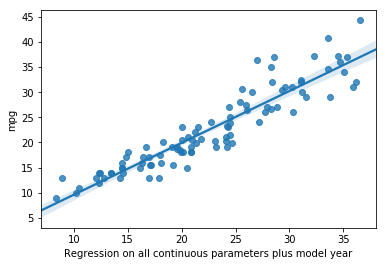

In [143]:
sns.regplot(x=all_col_plus_year.predict(test).ravel(), y=test['mpg'])
plt.xlabel('Regression on all continuous parameters plus model year')
plt.show()

## Individual region models

Repeat the analysis above but treat each country separately to try for better accuracy

### United States

In [144]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 2)]
us_two_var_regression = []
for c in cs:
    model = LinearRegression()
    model.fit(train[train.origin == 1], c, ['mpg'])
    us_two_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })

In [145]:
for m in us_two_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower']	4.426401262567752
['displacement', 'weight']	4.213159731945932
['displacement', 'acceleration']	4.388838642673567
['displacement', 'inverse horsepower']	4.103872083858961
['displacement', 'inverse displacement']	4.012835758527674
['displacement', 'inverse weight']	3.9954816057905966
['displacement', 'model year']	3.9183620874896863
['horsepower', 'weight']	4.301142581278587
['horsepower', 'acceleration']	4.968312115146527
['horsepower', 'inverse horsepower']	4.37384594477205
['horsepower', 'inverse displacement']	3.857801723595352
['horsepower', 'inverse weight']	3.9948000252711586
['horsepower', 'model year']	4.675443093300654
['weight', 'acceleration']	4.338896786204244
['weight', 'inverse horsepower']	4.024796254312836
['weight', 'inverse displacement']	3.8838558003946875
['weight', 'inverse weight']	4.115340356744184
['weight', 'model year']	3.6146113119756533
['acceleration', 'inverse horsepower']	4.025392045140939
['acceleration', 'inverse displacem

Now the best fit model uses `inverse weight` and `model year`, with similar accuracy. Since `inverse displacement` and `inverse weight` are so correlated (0.93) this is not surprising.

In [146]:
us_all_col_plus_year = LinearRegression()
us_all_col_plus_year.fit(train[train.origin == 1], continuous_columns[1:] + ['model year'], ['mpg'])
us_all_col_plus_year.rmse(test)

3.1835252292398857

### Europe

In [147]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 2)]
eu_two_var_regression = []
for c in cs:
    model = LinearRegression()
    model.fit(train[train.origin == 2], c, ['mpg'])
    eu_two_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })

In [148]:
for m in eu_two_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower']	9.44293654093564
['displacement', 'weight']	8.703335998981226
['displacement', 'acceleration']	15.906945747081066
['displacement', 'inverse horsepower']	7.787193572748441
['displacement', 'inverse displacement']	15.128204399092603
['displacement', 'inverse weight']	7.890201336439189
['displacement', 'model year']	18.371908645389556
['horsepower', 'weight']	5.223237854458529
['horsepower', 'acceleration']	5.340014282012458
['horsepower', 'inverse horsepower']	4.559136997330334
['horsepower', 'inverse displacement']	5.434603119635736
['horsepower', 'inverse weight']	4.737071122114614
['horsepower', 'model year']	5.028408699439854
['weight', 'acceleration']	5.083238951787287
['weight', 'inverse horsepower']	4.15145353510681
['weight', 'inverse displacement']	5.353660112105609
['weight', 'inverse weight']	4.499335432664842
['weight', 'model year']	4.082543908528381
['acceleration', 'inverse horsepower']	4.683363778189973
['acceleration', 'inverse displacement

European car mileage is best predicted by `inverse weight` and `model year`

In [149]:
eu_all_col_plus_year = LinearRegression()
eu_all_col_plus_year.fit(train[train.origin == 2], continuous_columns[1:] + ['model year'], ['mpg'])
eu_all_col_plus_year.rmse(test)

5.425477526714295

### Japan

In [150]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 2)]
jp_two_var_regression = []
for c in cs:
    model = LinearRegression()
    model.fit(train[train.origin == 3], c, ['mpg'])
    jp_two_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })

In [151]:
for m in jp_two_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower']	10.33868355151885
['displacement', 'weight']	5.980275338737515
['displacement', 'acceleration']	7.532267776281068
['displacement', 'inverse horsepower']	7.498036138017537
['displacement', 'inverse displacement']	31.163638528492896
['displacement', 'inverse weight']	6.790398969817599
['displacement', 'model year']	12.024564017915056
['horsepower', 'weight']	7.300334013844946
['horsepower', 'acceleration']	6.369513070514715
['horsepower', 'inverse horsepower']	9.110282375532101
['horsepower', 'inverse displacement']	7.712362467962595
['horsepower', 'inverse weight']	7.646991490936694
['horsepower', 'model year']	5.9223279023087265
['weight', 'acceleration']	6.808767878933457
['weight', 'inverse horsepower']	4.287585759778185
['weight', 'inverse displacement']	8.61670138062162
['weight', 'inverse weight']	6.790422167996758
['weight', 'model year']	7.871200380374051
['acceleration', 'inverse horsepower']	5.643708452246853
['acceleration', 'inverse displacemen

Japanese cars are like US cars in that they are also best predicted using `inverse weight` and `model year`

In [152]:
jp_all_col_plus_year = LinearRegression()
jp_all_col_plus_year.fit(train[train.origin == 3], continuous_columns[1:] + ['model year'], ['mpg'])
jp_all_col_plus_year.rmse(test)

10.310085395768638

# Unscaled regression

In [153]:
class UnscaledLinearRegression():
    def __init__(self):
        self.coefficients_ = None
        self.means_ = None
        self.stds_ = None
        self.x_columns_ = None
        self.y_column_ = None
    
    def fit(self, data, x_columns, y_column):
        x = data[x_columns].values
        y = data[y_column].values
        
        self.x_columns_ = x_columns
        self.y_column_ = y_column
        
        xs = self.zscore(x)
        
        self.coefficients_ = np.linalg.inv(xs.T @ xs) @ xs.T @ y
        
    def zscore(self, x):
        # Make sure x is 2-d
        if len(x.shape) < 2:
            x = x.reshape((-1, 1))
        
        if self.means_ is None and self.stds_ is None:
            self.means_ = np.mean(x, axis=0)
            self.stds_ = np.std(x, axis=0)
        
        #xs = (x - self.means_) / self.stds_
        xs = x
        
        # Add column of ones
        o = np.ones_like(xs[:,0]).reshape((-1, 1))
        xs = np.hstack([xs, o])
        
        return xs
        
    def predict(self, data):
        x = data[self.x_columns_].values
        xs = self.zscore(x)
        
        y_pred = xs @ self.coefficients_
        
        return y_pred
    
    def rmse(self, data):
        yp = self.predict(data)
        yt = data[self.y_column_].values
        
        se = (yp - yt) ** 2
        mse = np.mean(se)
        rmse = np.sqrt(mse)
        
        return rmse

In [154]:
unscaled_one_var_regression = []
for column in train_continuous.columns[1:]:
    model = UnscaledLinearRegression()
    model.fit(train, [column], ['mpg'])
    unscaled_one_var_regression.append({
        'name': column,
        'model': model,
        'performance': model.rmse(test)
    })
for m in one_var_regression:
    print(f"{m['name']}\t{m['performance']}")

displacement	4.366985707092861
horsepower	4.894898906789425
weight	4.241479426532961
acceleration	7.3651971223062995
inverse horsepower	4.344884244138614
inverse displacement	4.1363158374882225
inverse weight	4.215079885267199


Comparison of Scaled and Unscaled for two-variable regression. Positive values indicate that scaled is better; negative values indicate that unscaled is better

In [155]:
one_var_scaled_perf = np.array([m['performance'] for m in one_var_regression])
one_var_unscaled_perf = np.array([m['performance'] for m in unscaled_one_var_regression])
print(one_var_scaled_perf - one_var_unscaled_perf)

[-1.77635684e-15 -8.88178420e-16  6.21724894e-15  1.24344979e-14
 -8.88178420e-16  1.77635684e-15  8.88178420e-16]


In [156]:
cs = [list(_) for _ in combinations(continuous_columns[1:] + ['model year'], 2)]
unscaled_two_var_regression = []
for c in cs:
    model = UnscaledLinearRegression()
    model.fit(train, c, ['mpg'])
    unscaled_two_var_regression.append({
        'name': c,
        'model': model,
        'performance': model.rmse(test)
    })
for m in unscaled_two_var_regression:
    print(f"{m['name']}\t{m['performance']}")

['displacement', 'horsepower']	4.3448661991029915
['displacement', 'weight']	4.211041633397983
['displacement', 'acceleration']	4.367549009499186
['displacement', 'inverse horsepower']	3.942239693978216
['displacement', 'inverse displacement']	4.026047466998115
['displacement', 'inverse weight']	4.072163105232778
['displacement', 'model year']	3.762711367061384
['horsepower', 'weight']	4.161177036367436
['horsepower', 'acceleration']	4.752999094756582
['horsepower', 'inverse horsepower']	4.3584278342993015
['horsepower', 'inverse displacement']	3.859942709949313
['horsepower', 'inverse weight']	3.9777603679240188
['horsepower', 'model year']	4.488134996029496
['weight', 'acceleration']	4.200694339070752
['weight', 'inverse horsepower']	3.8790641540865183
['weight', 'inverse displacement']	3.968076129052115
['weight', 'inverse weight']	4.153079799701472
['weight', 'model year']	3.4303606764309675
['acceleration', 'inverse horsepower']	4.0657370268947535
['acceleration', 'inverse displac

In [157]:
two_var_scaled_perf = np.array([m['performance'] for m in two_var_regression])
two_var_unscaled_perf = np.array([m['performance'] for m in unscaled_two_var_regression])
print(one_var_scaled_perf - one_var_unscaled_perf)

[-1.77635684e-15 -8.88178420e-16  6.21724894e-15  1.24344979e-14
 -8.88178420e-16  1.77635684e-15  8.88178420e-16]


Since these regressions are linear, centering and scaling the data has no effect on the outcome!

# Polynomial features

In [158]:
class PolynomialRegressor(LinearRegression):
    def __init__(self, degree=1):
        super().__init__()
        self.degree_ = degree
        if degree < 1:
            raise ValueError(f"Degree must be 1 or greater, not {degree}")
    
    def make_poly_cols(self, data, x_cols):
        x_poly = data.copy()
        
        new_x_cols = x_cols[:]
        
        for i in range(2, self.degree_ + 1):
            for c in x_cols:
                colname = f"{c}^{i}"
                x_poly[colname] = x_poly[c] ** i
                new_x_cols.append(colname)
        
        return x_poly, new_x_cols
    
    def fit(self, data, x_cols, y_col):
        self.x_columns_ = x_cols
        self.y_column_ = y_col
        
        x, xc = self.make_poly_cols(data, x_cols)
        x = x[xc].values
        
        xs = self.zscore(x)
        
        y = data[y_col].values
        
        self.coefficients_ = np.linalg.inv(xs.T @ xs) @ xs.T @ y
    
    def predict(self, data):
        x, xc = self.make_poly_cols(data, self.x_columns_)
        x = x[xc].values
        
        xs = self.zscore(x)
        
        y_pred = xs @ self.coefficients_
        
        return y_pred

In [159]:
# Verify that this is the same for the degree=1 case
pr = PolynomialRegressor(1)
lr = LinearRegression()
pr.fit(train, ['weight', 'model year'], ['mpg'])
lr.fit(train, ['weight', 'model year'], ['mpg'])
assert pr.rmse(train) == lr.rmse(train)

In [160]:
best_model_vs_degree = []
for degree in range(1,6):
    input_columns = continuous_columns[1:] + ['model year']
    best_model_perf = []
    for i in range(1,len(input_columns)+1):
        cs = [list(_) for _ in combinations(input_columns, i)]
        #print(cs)
        best_perf = 1000000
        for c in cs:
            model = PolynomialRegressor(degree)
            model.fit(train, c, ['mpg'])
            best_perf = min([model.rmse(test), best_perf])
        best_model_perf.append(best_perf)
    best_model_vs_degree.append(best_model_perf)

In [161]:
perf_array = np.array(best_model_vs_degree)
print(f"Error of best model: {np.min(perf_array)}")
print(f"Location of best model: {np.where(perf_array == np.min(perf_array))}")

Error of best model: 2.5870124751553787
Location of best model: (array([2]), array([4]))


In [162]:
print(perf_array)

[[4.13631584 3.12316562 3.04786698 2.84092201 2.84129326 2.83625545
  2.95527236 2.98673275]
 [3.92605039 3.04060227 2.85598592 2.69430922 2.65810518 2.64472105
  2.75077417 2.75796764]
 [3.87914716 2.95197054 2.68268926 2.58763472 2.58701248 2.67245212
  2.71997652 2.80785888]
 [4.03728655 2.98528807 2.78710798 2.70612468 2.70152164 2.7978954
  2.87644019 3.06492927]
 [4.05743096 3.00219645 2.81388608 2.75258826 2.75120326 2.82123357
  2.82532934 3.13661458]]


It appears the most accurate model on the test set had five column inputs and was of degree three. 

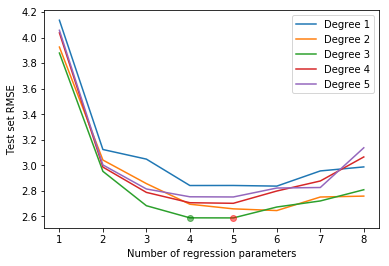

In [163]:
for i in range(perf_array.shape[0]):
    best_model_perf = perf_array[i]
    plt.plot(best_model_perf, label=f"Degree {i+1}")
    plt.xlabel('Number of regression parameters')
    plt.ylabel('Test set RMSE')
    xticks = [_ for _ in range(len(best_model_perf))]
    xtick_labels = [_+1 for _ in range(len(best_model_perf))]
    plt.legend(loc='upper right')
plt.plot(4, perf_array[2, 4], 'ro', alpha=0.5)
plt.plot(3, perf_array[2, 3], 'go', alpha=0.5)
plt.xticks(xticks, xtick_labels)
plt.savefig(join(imdir, 'polynomial_regression_performance.png'), dpi=300)
plt.show()

In [164]:
input_columns = continuous_columns[1:] + ['model year']
best_model_perf = []
cs = [list(_) for _ in combinations(input_columns, 4)]
#print(cs)
best_perf = 1000000
best_model = None
for c in cs:
    model = PolynomialRegressor(3)
    model.fit(train, c, ['mpg'])
    best_perf = min([model.rmse(test), best_perf])
    if best_perf == model.rmse(test):
        best_model = model
best_model_perf.append(best_perf)
index = best_model_perf.index(min(best_model_perf))
print(f"The best model had inputs: {cs[index]}")

The best model had inputs: ['displacement', 'horsepower', 'weight', 'acceleration']


/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


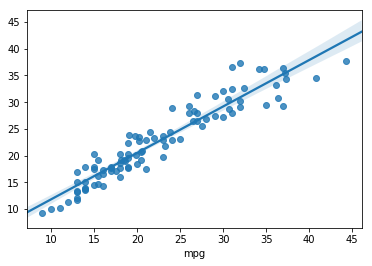

In [165]:
sns.regplot(test[('mpg')], best_model.predict(test).ravel())
plt.show()

In [166]:
best_model = LinearRegression()
best_model.fit(train, ['acceleration', 'inverse horsepower', 'inverse displacement', 'model year'], ['mpg'])
best_model.rmse(val)


3.0229468144029523